In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from efficientnet_pytorch import EfficientNet


print ("testing")

testing


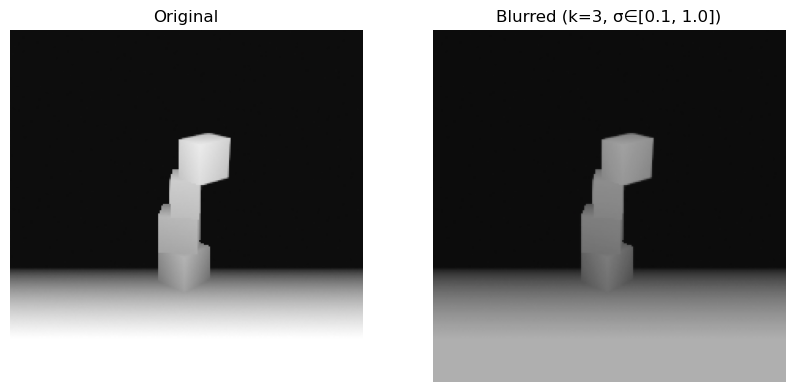

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
#testing
img = Image.open("DEPTH_COMBINED DATASET2/test/Unstable/4B-3D-Non-Rot-Cube-yaxis_SPLIT_render_167_persp_left.png").resize((224, 224))

blur_transform = transforms.GaussianBlur(kernel_size=3, sigma=(0.3, 0.6))
c_transform = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue = 0.3)
# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Blurred (k=3, σ∈[0.1, 1.0])")
blurred_img = blur_transform(c_transform(img))
plt.imshow(blurred_img)
plt.axis('off')
plt.show()

In [5]:
# Define data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue = 0.3),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.3, 0.6)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
train = datasets.ImageFolder(root='MAIN_DS/4B-3D-Uni/train', transform=transform)
val = datasets.ImageFolder(root='MAIN_DS/4B-3D-Uni/val', transform=transform)
test = datasets.ImageFolder(root='MAIN_DS/4B-3D-Uni/test', transform=transform)

train_loader = DataLoader(train, batch_size=16, shuffle=True)
val_loader = DataLoader(val, batch_size=16, shuffle=True)
test_loader = DataLoader(test, batch_size=16, shuffle=False)

print(f"Training set size: {len(train)} images")
print(f"Training set size: {len(val)} images")
print(f"Testing set size: {len(test)} images")

Training set size: 1200 images
Training set size: 400 images
Testing set size: 400 images


In [9]:
# Loading the pre-trained EfficientNet-B0 model
efficientnet_b0 = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the classifier layer for binary classification
num_features = efficientnet_b0._fc.in_features
efficientnet_b0._fc = nn.Linear(num_features, 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
efficientnet_b0 = efficientnet_b0.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(efficientnet_b0.parameters(), lr=0.001, weight_decay=0.01)

Loaded pretrained weights for efficientnet-b0
Using device: cuda


In [11]:
def evaluate_model(model, data_loader):
    """Evaluate model on the provided data loader"""
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total * 100
    avg_loss = running_loss / len(data_loader)
    return accuracy, avg_loss

In [88]:
import torch.optim.lr_scheduler as lr_scheduler

num_epochs = 30
best_val_accuracy = 0.0
best_val_loss = float('inf')
patience = 10 
no_improvement_count = 0
temp = None
print("Starting")

# Reduce LR on plateauing validation loss
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)

for epoch in range(num_epochs):
    # Training phase
    efficientnet_b0.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = efficientnet_b0(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
       
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
   
    train_accuracy = correct / total * 100
    train_loss = running_loss / len(train_loader)
    
    val_accuracy, val_loss = evaluate_model(efficientnet_b0, val_loader)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_accuracy = val_accuracy  # 
        temp = efficientnet_b0.state_dict()
        no_improvement_count = 0 
    else:
        no_improvement_count += 1
    
    
    scheduler.step(val_loss)
    
    
    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    print(f'Best Validation Loss: {best_val_loss:.4f}, Best Accuracy: {best_val_accuracy:.2f}%')
    print(f'Current LR: {optimizer.param_groups[0]["lr"]:.6f}')
    print(f'Patience counter: {no_improvement_count}/{patience}')
    print('-' * 60)
    
    
    if no_improvement_count >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs!')
        break

torch.save(temp, 'saved_models/EfficientNet-B0/4B-3D-Uni_new.pth')
print("Training completed.")

Starting training...
Epoch [1/30]
Training Loss: 0.2594, Training Accuracy: 89.83%
Validation Loss: 0.6647, Validation Accuracy: 86.75%
Best Validation Loss: 0.6647, Best Accuracy: 86.75%
Current LR: 0.001000
Patience counter: 0/10
------------------------------------------------------------
Epoch [2/30]
Training Loss: 0.2271, Training Accuracy: 92.42%
Validation Loss: 0.3208, Validation Accuracy: 90.50%
Best Validation Loss: 0.3208, Best Accuracy: 90.50%
Current LR: 0.001000
Patience counter: 0/10
------------------------------------------------------------
Epoch [3/30]
Training Loss: 0.1861, Training Accuracy: 93.42%
Validation Loss: 0.2190, Validation Accuracy: 93.00%
Best Validation Loss: 0.2190, Best Accuracy: 93.00%
Current LR: 0.001000
Patience counter: 0/10
------------------------------------------------------------
Epoch [4/30]
Training Loss: 0.2036, Training Accuracy: 92.33%
Validation Loss: 0.3648, Validation Accuracy: 87.50%
Best Validation Loss: 0.2190, Best Accuracy: 93.

In [19]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test = datasets.ImageFolder(root='NEW_parameters/Cubes', transform=test_transform)
test_loader = DataLoader(test, batch_size=16, shuffle=False)

efficientnet_b0 = EfficientNet.from_pretrained('efficientnet-b0')
    
efficientnet_b0._fc = torch.nn.Linear(efficientnet_b0._fc.in_features, 2)

efficientnet_b0.load_state_dict(torch.load('Combined_model.pth'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
efficientnet_b0 = efficientnet_b0.to(device)

efficientnet_b0.eval()
test_accuracy, test_loss = evaluate_model(efficientnet_b0, test_loader)

print(f'\nFinal Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Loaded pretrained weights for efficientnet-b0


C:\Users\ajeet\AppData\Local\Temp\ipykernel_24860\3053207189.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_b0.load_state_dict(torch.load('Combined_model.


Final Test Loss: 1.8061, Test Accuracy: 63.00%


Loaded pretrained weights for efficientnet-b0


C:\Users\ajeet\AppData\Local\Temp\ipykernel_31068\663193277.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_b0.load_state_dict(torch.load('saved_models/Comb

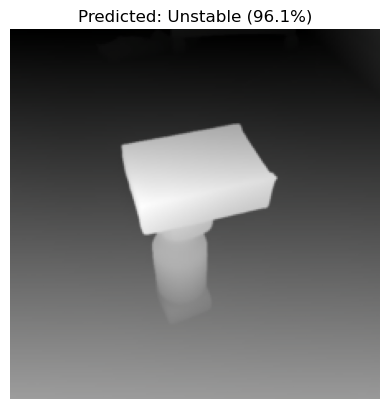


Predicted Stability: Unstable


In [70]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

efficientnet_b0 = EfficientNet.from_pretrained('efficientnet-b0')
efficientnet_b0._fc = torch.nn.Linear(efficientnet_b0._fc.in_features, 2)
efficientnet_b0.load_state_dict(torch.load('saved_models/Combined-DEPTH4.pth'))
efficientnet_b0.eval()
efficientnet_b0.to(device)

transform = transforms.Compose([
    transforms.Resize(224),# 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class_names = ['Stable', 'Unstable']

def predict_stability(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    
    with torch.no_grad():
        outputs = efficientnet_b0(image)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0] * 100


        
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    plt.imshow(inv_normalize(image.squeeze(0)).permute(1, 2, 0).cpu())

    plt.axis('off')
    plt.title(f"Predicted: {class_names[predicted.item()]} ({probabilities[predicted.item()]:.1f}%)")
    plt.show()
    
    return class_names[predicted.item()]

image_path = "Inference/tmpp7t1y6ur.png"
prediction = predict_stability(image_path)
print(f"\nPredicted Stability: {prediction}")

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model_with_confusion(model, test_loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
   
    all_preds = []
    all_labels = []
    
    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    
    return avg_loss, accuracy, all_labels, all_preds

In [13]:
def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    from sklearn.metrics import classification_report
    print(classification_report(labels, preds, target_names=class_names))


Final Test Loss: 1.1354, Test Accuracy: 71.60%


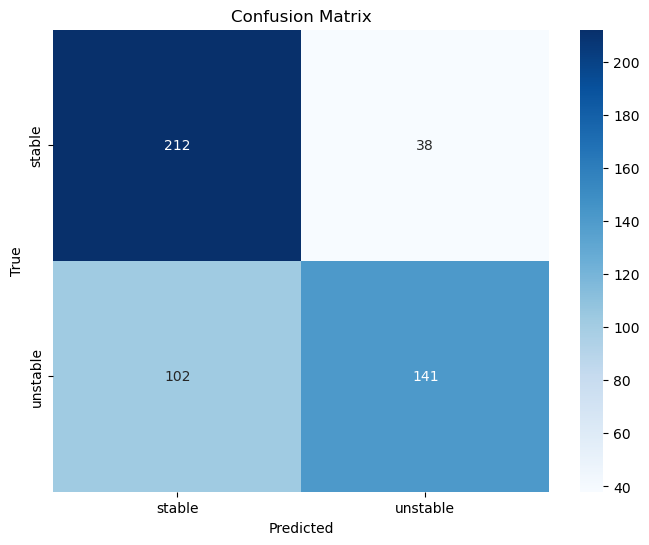

              precision    recall  f1-score   support

      stable       0.68      0.85      0.75       250
    unstable       0.79      0.58      0.67       243

    accuracy                           0.72       493
   macro avg       0.73      0.71      0.71       493
weighted avg       0.73      0.72      0.71       493



In [14]:
# Run evaluation

test = datasets.ImageFolder(root='Real_Labelled_data_d', transform=test_transform)
test_loader = DataLoader(test, batch_size=16, shuffle=False)
test_loss, test_accuracy, true_labels, pred_labels = evaluate_model_with_confusion(efficientnet_b0, test_loader)

print(f'\nFinal Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

class_names = ['stable', 'unstable']

plot_confusion_matrix(true_labels, pred_labels, class_names)


Processing image: render_01_persp_left.png


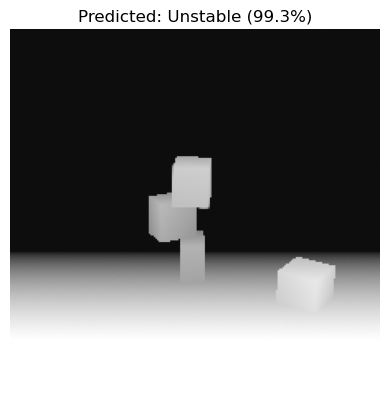

Predicted Stability: Unstable

Processing image: stable.png


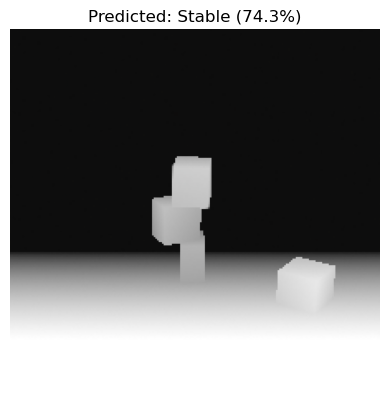

Predicted Stability: Stable

Processing image: Unstable.png


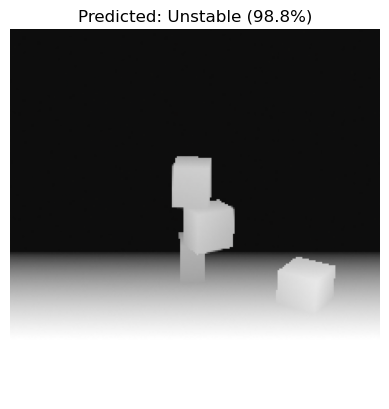

Predicted Stability: Unstable

Processing image: Unstable1.png


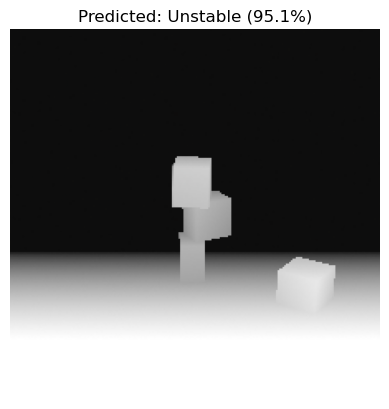

Predicted Stability: Unstable

Processing image: Unstable2.png


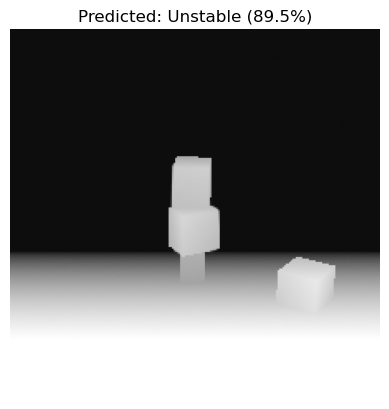

Predicted Stability: Unstable

Processing image: Unstable3.png


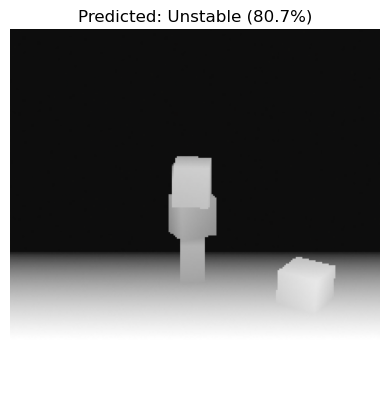

Predicted Stability: Unstable


In [117]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

def predict_stability(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = efficientnet_b0(image)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0] * 100

    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    plt.imshow(inv_normalize(image.squeeze(0)).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.title(f"Predicted: {class_names[predicted.item()]} ({probabilities[predicted.item()]:.1f}%)")
    plt.show()
    
    return class_names[predicted.item()]


folder_path = "OG_DS/Stabilising_scenes/Combined"


image_extensions = ['.png', '.jpg', '.jpeg']
image_files = [f for f in os.listdir(folder_path) 
               if os.path.isfile(os.path.join(folder_path, f)) 
               and os.path.splitext(f)[1].lower() in image_extensions]

for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    print(f"\nProcessing image: {image_file}")
    
    try:
        prediction = predict_stability(image_path)
        print(f"Predicted Stability: {prediction}")
    except Exception as e:
        print(f"Error processing {image_file}: {str(e)}")